In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree("/content/drive/MyDrive/assignment2-dataset/food11", "/content/food11")

'/content/food11'

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/content/food11"

In [ ]:
# Data augmentation (for only train)
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the Datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "validation"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)

# PART 1

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResidualCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_prob=0.5):
        super(ResidualCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(64, 64),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            ResidualBlock(128, 256),
        )

        # Dynamic flatten size
        self.flatten_size = self._get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, num_classes),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)  # Dummy input
            out = self.features(dummy)
            return out.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [ ]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    model = model.to(device)
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = calculate_accuracy(model, train_loader)
        val_accuracy = calculate_accuracy(model, val_loader)

        train_loss_list.append(epoch_loss)
        train_acc_list.append(train_accuracy)
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Loss: {epoch_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

    return train_loss_list, train_acc_list, val_acc_list

## **Basic CNN Models with Different Batchsize and Learning Rates**

Batchsize = 32, Learning Rate = 0.001

Epoch [1/50] - Loss: 21.4045, Train Acc: 0.0941, Val Acc: 0.0873
Epoch [2/50] - Loss: 2.3983, Train Acc: 0.0950, Val Acc: 0.0909
Epoch [3/50] - Loss: 2.3950, Train Acc: 0.1023, Val Acc: 0.0945
Epoch [4/50] - Loss: 2.3980, Train Acc: 0.0964, Val Acc: 0.0945
Epoch [5/50] - Loss: 2.3969, Train Acc: 0.0968, Val Acc: 0.0945
Epoch [6/50] - Loss: 2.3964, Train Acc: 0.1014, Val Acc: 0.0909
Epoch [7/50] - Loss: 2.3943, Train Acc: 0.0927, Val Acc: 0.0873
Epoch [8/50] - Loss: 2.3957, Train Acc: 0.0991, Val Acc: 0.0836
Epoch [9/50] - Loss: 2.3950, Train Acc: 0.0977, Val Acc: 0.0945
Epoch [10/50] - Loss: 2.3941, Train Acc: 0.0909, Val Acc: 0.0909
Epoch [11/50] - Loss: 2.3982, Train Acc: 0.0909, Val Acc: 0.0909
Epoch [12/50] - Loss: 2.3981, Train Acc: 0.0909, Val Acc: 0.0909
Epoch [13/50] - Loss: 2.3954, Train Acc: 0.0973, Val Acc: 0.0909
Epoch [14/50] - Loss: 2.3994, Train Acc: 0.0909, Val Acc: 0.0909
Epoch [15/50] - Loss: 2.3982, Train Acc: 0.0909, Val Acc: 0.0909
Epoch [16/50] - Loss: 2.3981, Tra

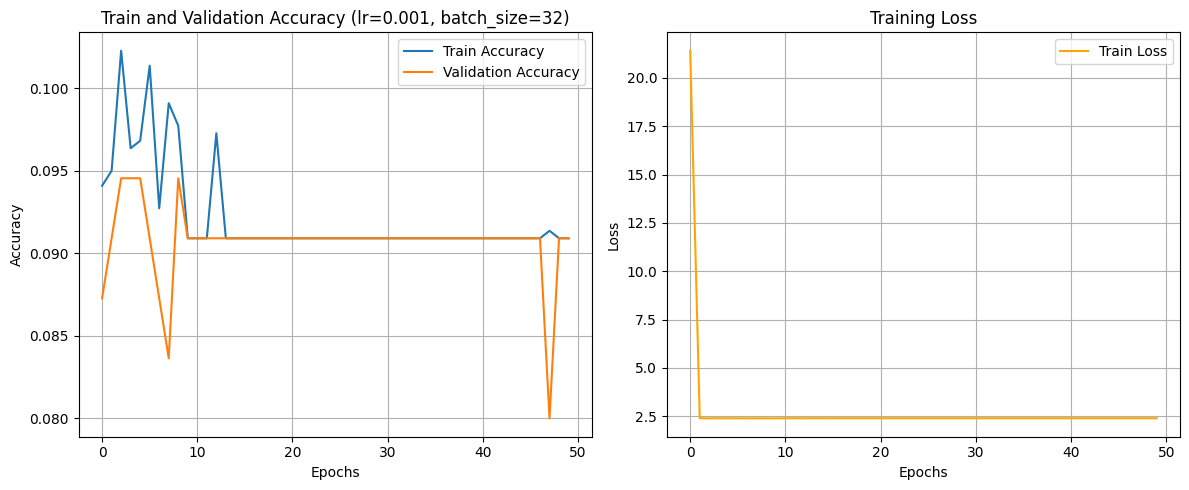

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = get_dataloaders(batch_size)

model = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, train_acc, val_acc = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.001, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 32, learning rate = 0.0001

Epoch [1/50] - Loss: 5.0999, Train Acc: 0.1959, Val Acc: 0.1745
Epoch [2/50] - Loss: 2.2975, Train Acc: 0.2168, Val Acc: 0.1745
Epoch [3/50] - Loss: 2.2016, Train Acc: 0.2723, Val Acc: 0.2036
Epoch [4/50] - Loss: 2.1238, Train Acc: 0.3168, Val Acc: 0.2655
Epoch [5/50] - Loss: 2.0530, Train Acc: 0.3082, Val Acc: 0.2945
Epoch [6/50] - Loss: 2.0456, Train Acc: 0.3150, Val Acc: 0.2800
Epoch [7/50] - Loss: 1.9696, Train Acc: 0.3418, Val Acc: 0.3236
Epoch [8/50] - Loss: 1.8881, Train Acc: 0.3791, Val Acc: 0.3673
Epoch [9/50] - Loss: 1.8847, Train Acc: 0.3991, Val Acc: 0.3818
Epoch [10/50] - Loss: 1.8138, Train Acc: 0.3827, Val Acc: 0.3709
Epoch [11/50] - Loss: 1.7539, Train Acc: 0.4341, Val Acc: 0.3745
Epoch [12/50] - Loss: 1.7349, Train Acc: 0.4618, Val Acc: 0.3964
Epoch [13/50] - Loss: 1.7202, Train Acc: 0.4518, Val Acc: 0.3891
Epoch [14/50] - Loss: 1.6856, Train Acc: 0.4309, Val Acc: 0.4073
Epoch [15/50] - Loss: 1.6373, Train Acc: 0.4541, Val Acc: 0.3818
Epoch [16/50] - Loss: 1.6103, Trai

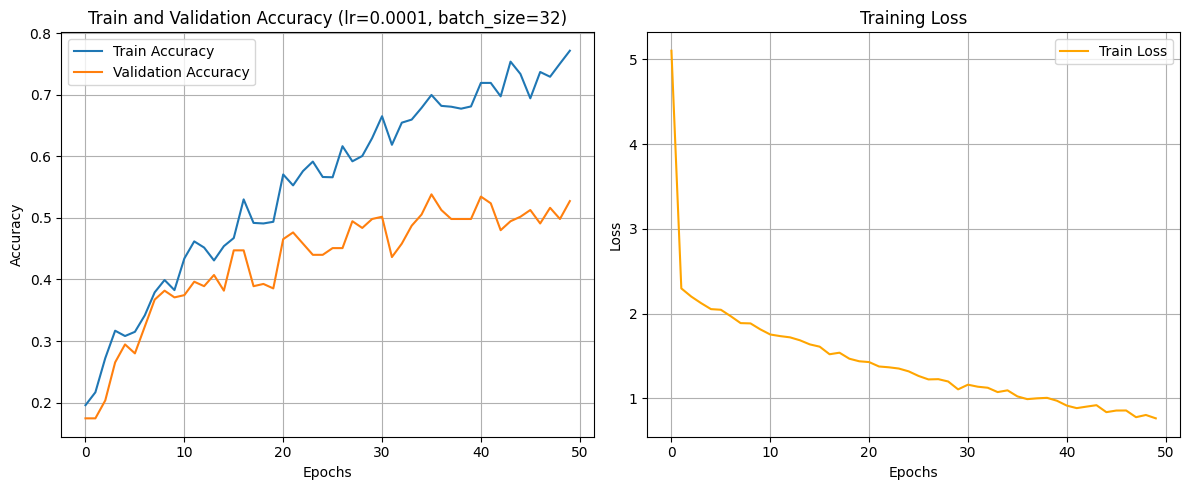

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = get_dataloaders(batch_size)

model1 = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)

train_loss1, train_acc1, val_acc1 = train_model(
    model1,
    train_loader,
    val_loader,
    criterion,
    optimizer1,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc1, label='Train Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss1, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 32, learning rate = 0.0005

Epoch [1/50] - Loss: 15.4889, Train Acc: 0.1291, Val Acc: 0.0982
Epoch [2/50] - Loss: 2.5479, Train Acc: 0.1850, Val Acc: 0.1382
Epoch [3/50] - Loss: 2.4266, Train Acc: 0.2432, Val Acc: 0.2255
Epoch [4/50] - Loss: 2.3432, Train Acc: 0.2395, Val Acc: 0.2255
Epoch [5/50] - Loss: 2.2511, Train Acc: 0.2632, Val Acc: 0.2873
Epoch [6/50] - Loss: 2.1737, Train Acc: 0.2545, Val Acc: 0.2291
Epoch [7/50] - Loss: 2.1477, Train Acc: 0.2627, Val Acc: 0.2909
Epoch [8/50] - Loss: 2.0752, Train Acc: 0.2991, Val Acc: 0.3127
Epoch [9/50] - Loss: 1.9927, Train Acc: 0.3427, Val Acc: 0.3527
Epoch [10/50] - Loss: 1.9863, Train Acc: 0.3455, Val Acc: 0.3455
Epoch [11/50] - Loss: 1.9586, Train Acc: 0.3400, Val Acc: 0.3418
Epoch [12/50] - Loss: 1.9385, Train Acc: 0.3405, Val Acc: 0.3236
Epoch [13/50] - Loss: 1.9608, Train Acc: 0.3614, Val Acc: 0.3818
Epoch [14/50] - Loss: 1.9371, Train Acc: 0.3700, Val Acc: 0.3491
Epoch [15/50] - Loss: 1.8714, Train Acc: 0.3873, Val Acc: 0.3527
Epoch [16/50] - Loss: 1.8592, Tra

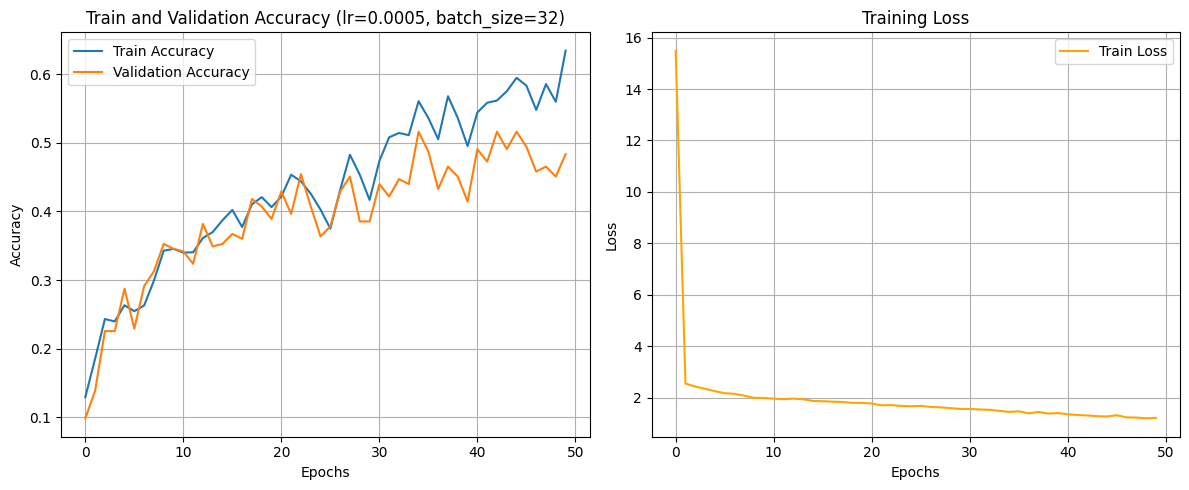

In [ ]:
model2 = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0005)

train_loss2, train_acc2, val_acc2 = train_model(
    model2,
    train_loader,
    val_loader,
    criterion,
    optimizer2,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc2, label='Train Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0005, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss2, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, learning rate = 0.001

Epoch [1/50] - Loss: 32.9876, Train Acc: 0.0932, Val Acc: 0.0873
Epoch [2/50] - Loss: 4.7647, Train Acc: 0.1495, Val Acc: 0.1309
Epoch [3/50] - Loss: 3.2096, Train Acc: 0.1505, Val Acc: 0.1527
Epoch [4/50] - Loss: 2.8248, Train Acc: 0.2095, Val Acc: 0.1709
Epoch [5/50] - Loss: 2.4602, Train Acc: 0.2459, Val Acc: 0.2073
Epoch [6/50] - Loss: 2.3181, Train Acc: 0.2532, Val Acc: 0.2473
Epoch [7/50] - Loss: 2.3716, Train Acc: 0.2495, Val Acc: 0.2291
Epoch [8/50] - Loss: 2.1924, Train Acc: 0.3073, Val Acc: 0.2582
Epoch [9/50] - Loss: 2.0898, Train Acc: 0.2332, Val Acc: 0.2691
Epoch [10/50] - Loss: 2.1017, Train Acc: 0.3409, Val Acc: 0.2873
Epoch [11/50] - Loss: 2.0745, Train Acc: 0.3123, Val Acc: 0.3018
Epoch [12/50] - Loss: 2.0148, Train Acc: 0.3355, Val Acc: 0.3018
Epoch [13/50] - Loss: 1.9574, Train Acc: 0.3545, Val Acc: 0.3200
Epoch [14/50] - Loss: 1.9306, Train Acc: 0.3514, Val Acc: 0.3273
Epoch [15/50] - Loss: 1.9776, Train Acc: 0.3109, Val Acc: 0.2800
Epoch [16/50] - Loss: 1.9232, Tra

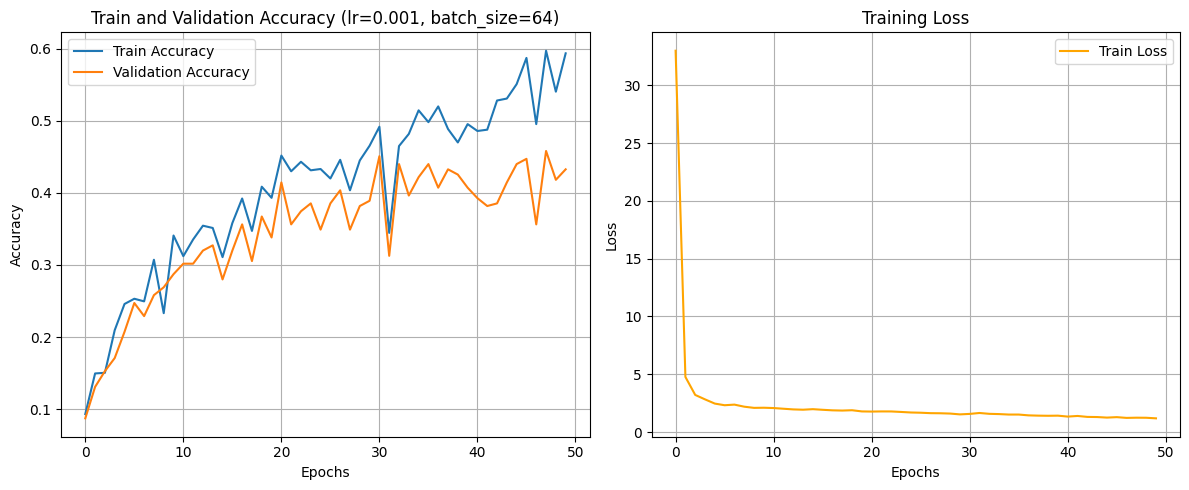

In [ ]:
batch_size_64 = 64
train_loader_64, val_loader_64, test_loader_64 = get_dataloaders(batch_size_64)

model3 = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

train_loss3, train_acc3, val_acc3 = train_model(
    model3,
    train_loader_64,
    val_loader_64,
    criterion,
    optimizer3,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc3, label='Train Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.001, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss3, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, learning rate = 0.0001

Epoch [1/50] - Loss: 6.1865, Train Acc: 0.1350, Val Acc: 0.1164
Epoch [2/50] - Loss: 2.3049, Train Acc: 0.2155, Val Acc: 0.1927
Epoch [3/50] - Loss: 2.2194, Train Acc: 0.2573, Val Acc: 0.2400
Epoch [4/50] - Loss: 2.1360, Train Acc: 0.2609, Val Acc: 0.2509
Epoch [5/50] - Loss: 2.0614, Train Acc: 0.3227, Val Acc: 0.3345
Epoch [6/50] - Loss: 1.9969, Train Acc: 0.3168, Val Acc: 0.3200
Epoch [7/50] - Loss: 1.9699, Train Acc: 0.3645, Val Acc: 0.3745
Epoch [8/50] - Loss: 1.9035, Train Acc: 0.3782, Val Acc: 0.3491
Epoch [9/50] - Loss: 1.8517, Train Acc: 0.3877, Val Acc: 0.3818
Epoch [10/50] - Loss: 1.8268, Train Acc: 0.4064, Val Acc: 0.3673
Epoch [11/50] - Loss: 1.7972, Train Acc: 0.4255, Val Acc: 0.3600
Epoch [12/50] - Loss: 1.7283, Train Acc: 0.4473, Val Acc: 0.4364
Epoch [13/50] - Loss: 1.7014, Train Acc: 0.4323, Val Acc: 0.3818
Epoch [14/50] - Loss: 1.6712, Train Acc: 0.4868, Val Acc: 0.4073
Epoch [15/50] - Loss: 1.6251, Train Acc: 0.4209, Val Acc: 0.3855
Epoch [16/50] - Loss: 1.6446, Trai

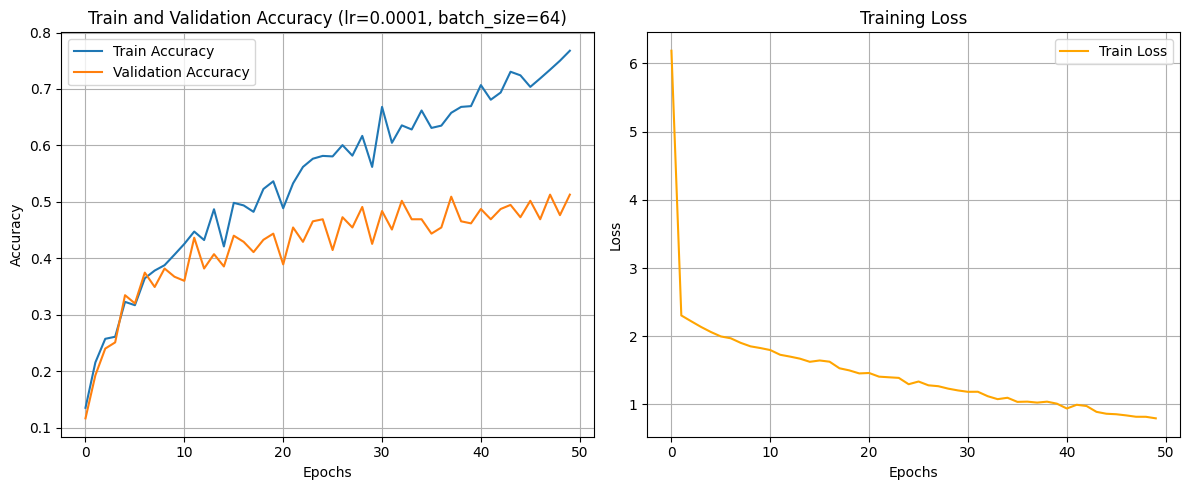

In [ ]:
model4 = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001)

train_loss4, train_acc4, val_acc4 = train_model(
    model4,
    train_loader_64,
    val_loader_64,
    criterion,
    optimizer4,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc4, label='Train Accuracy')
plt.plot(val_acc4, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss4, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, learning rate = 0.0005

Epoch [1/50] - Loss: 20.4768, Train Acc: 0.0873, Val Acc: 0.0800
Epoch [2/50] - Loss: 2.4813, Train Acc: 0.1445, Val Acc: 0.1382
Epoch [3/50] - Loss: 2.3295, Train Acc: 0.1636, Val Acc: 0.1418
Epoch [4/50] - Loss: 2.3074, Train Acc: 0.2068, Val Acc: 0.1709
Epoch [5/50] - Loss: 2.2616, Train Acc: 0.1864, Val Acc: 0.1600
Epoch [6/50] - Loss: 2.2784, Train Acc: 0.2127, Val Acc: 0.2218
Epoch [7/50] - Loss: 2.2107, Train Acc: 0.2468, Val Acc: 0.2509
Epoch [8/50] - Loss: 2.1887, Train Acc: 0.2418, Val Acc: 0.1855
Epoch [9/50] - Loss: 2.1562, Train Acc: 0.2518, Val Acc: 0.2291
Epoch [10/50] - Loss: 2.1543, Train Acc: 0.2391, Val Acc: 0.1891
Epoch [11/50] - Loss: 2.0937, Train Acc: 0.2932, Val Acc: 0.2509
Epoch [12/50] - Loss: 2.0773, Train Acc: 0.3018, Val Acc: 0.2691
Epoch [13/50] - Loss: 2.0792, Train Acc: 0.2782, Val Acc: 0.2145
Epoch [14/50] - Loss: 2.0419, Train Acc: 0.3086, Val Acc: 0.2727
Epoch [15/50] - Loss: 2.0060, Train Acc: 0.3114, Val Acc: 0.3200
Epoch [16/50] - Loss: 1.9710, Tra

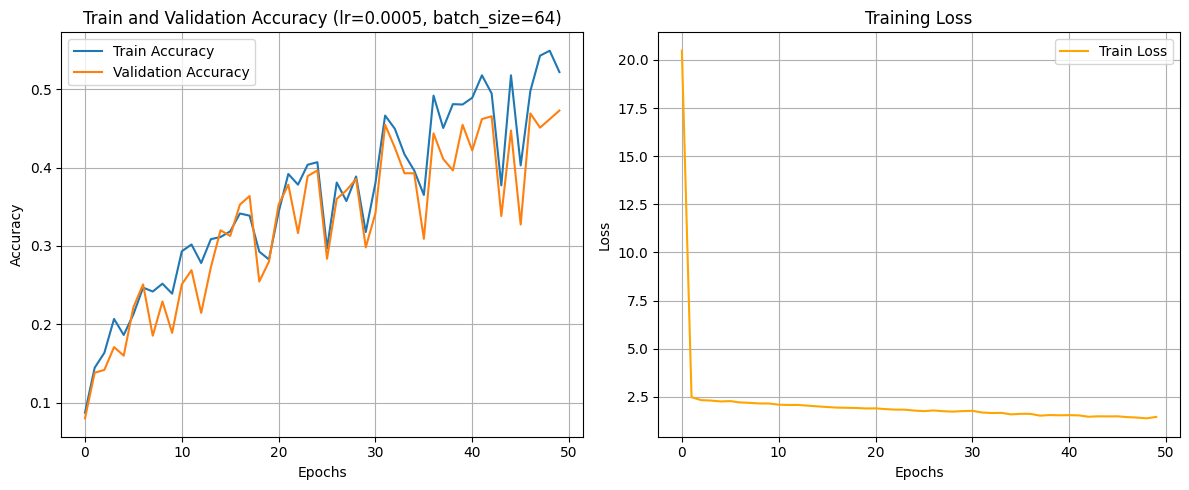

In [ ]:
model5 = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.0005)

train_loss5, train_acc5, val_acc5 = train_model(
    model5,
    train_loader_64,
    val_loader_64,
    criterion,
    optimizer5,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc5, label='Train Accuracy')
plt.plot(val_acc5, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0005, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss5, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**The best result was achieved at the learning rate of 0,0001 and batch size of 32.**

Loss: 0.7653 - Train Acc: 0.7714 - Val Acc: 0.5273

In [ ]:
best_model = model1
test_accuracy = calculate_accuracy(best_model, test_loader)
print(f"Test Accuracy (with best validation model): {test_accuracy:.4f}")

Test Accuracy (with best validation model): 0.4655


### Basic Cnn with Dropout Probability

In [ ]:
class BasicCNN_Dropout(nn.Module):
    def __init__(self, num_classes=11, dropout_prob=0.5):
        super(BasicCNN_Dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Batchsize = 32, Learning Rate = 0.0001, Dropout Probability = 0.3

Epoch [1/50] - Loss: 4.2211, Train Acc: 0.1341, Val Acc: 0.1564
Epoch [2/50] - Loss: 2.3762, Train Acc: 0.1445, Val Acc: 0.1527
Epoch [3/50] - Loss: 2.3624, Train Acc: 0.1477, Val Acc: 0.1273
Epoch [4/50] - Loss: 2.3389, Train Acc: 0.1627, Val Acc: 0.1491
Epoch [5/50] - Loss: 2.3033, Train Acc: 0.1732, Val Acc: 0.1891
Epoch [6/50] - Loss: 2.2992, Train Acc: 0.2018, Val Acc: 0.1600
Epoch [7/50] - Loss: 2.2708, Train Acc: 0.2205, Val Acc: 0.1927
Epoch [8/50] - Loss: 2.2334, Train Acc: 0.2455, Val Acc: 0.2291
Epoch [9/50] - Loss: 2.2108, Train Acc: 0.2509, Val Acc: 0.2218
Epoch [10/50] - Loss: 2.2014, Train Acc: 0.2695, Val Acc: 0.2727
Epoch [11/50] - Loss: 2.1576, Train Acc: 0.2532, Val Acc: 0.2473
Epoch [12/50] - Loss: 2.1546, Train Acc: 0.3018, Val Acc: 0.3055
Epoch [13/50] - Loss: 2.1223, Train Acc: 0.3036, Val Acc: 0.3600
Epoch [14/50] - Loss: 2.1185, Train Acc: 0.3009, Val Acc: 0.2836
Epoch [15/50] - Loss: 2.1029, Train Acc: 0.3173, Val Acc: 0.3200
Epoch [16/50] - Loss: 2.0628, Trai

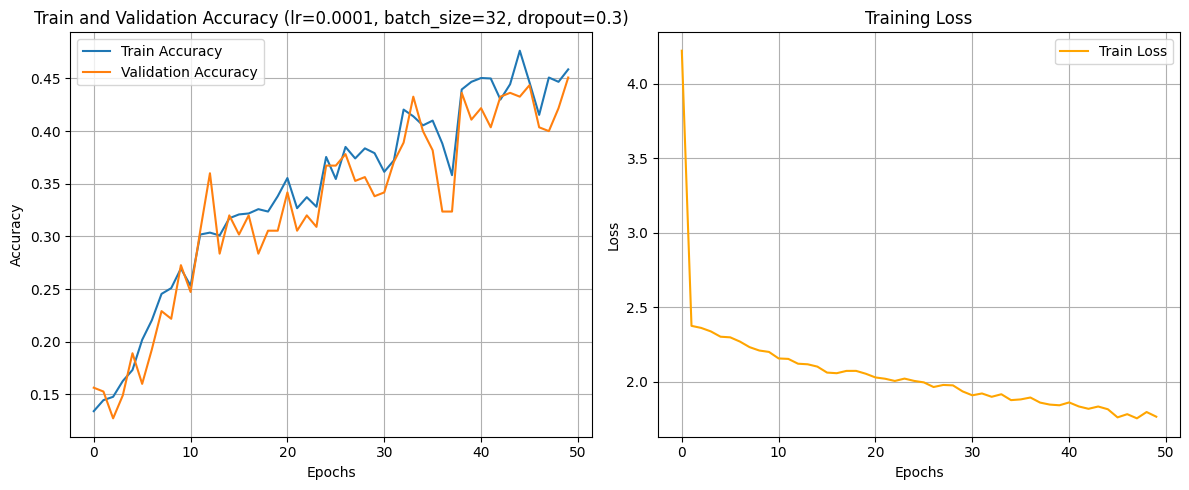

In [ ]:
model_dropout = BasicCNN_Dropout(dropout_prob=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.0001)

train_loss_dropout, train_acc_dropout, val_acc_dropout = train_model(
    model_dropout,
    train_loader,
    val_loader,
    criterion,
    optimizer_dropout,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_dropout, label='Train Accuracy')
plt.plot(val_acc_dropout, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32, dropout=0.3)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_dropout, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 32, Learning Rate = 0.0001, Dropout Probability = 0.5

Epoch [1/50] - Loss: 4.3651, Train Acc: 0.1595, Val Acc: 0.1236
Epoch [2/50] - Loss: 2.3616, Train Acc: 0.1777, Val Acc: 0.1673
Epoch [3/50] - Loss: 2.3681, Train Acc: 0.1823, Val Acc: 0.1709
Epoch [4/50] - Loss: 2.3396, Train Acc: 0.2045, Val Acc: 0.1673
Epoch [5/50] - Loss: 2.3201, Train Acc: 0.2059, Val Acc: 0.1418
Epoch [6/50] - Loss: 2.3141, Train Acc: 0.2182, Val Acc: 0.2182
Epoch [7/50] - Loss: 2.2934, Train Acc: 0.2191, Val Acc: 0.2000
Epoch [8/50] - Loss: 2.2758, Train Acc: 0.2150, Val Acc: 0.2218
Epoch [9/50] - Loss: 2.2849, Train Acc: 0.2118, Val Acc: 0.2036
Epoch [10/50] - Loss: 2.2901, Train Acc: 0.2191, Val Acc: 0.2364
Epoch [11/50] - Loss: 2.2680, Train Acc: 0.2305, Val Acc: 0.2473
Epoch [12/50] - Loss: 2.2540, Train Acc: 0.2482, Val Acc: 0.2436
Epoch [13/50] - Loss: 2.2385, Train Acc: 0.2418, Val Acc: 0.2473
Epoch [14/50] - Loss: 2.2334, Train Acc: 0.2509, Val Acc: 0.2145
Epoch [15/50] - Loss: 2.2254, Train Acc: 0.2582, Val Acc: 0.2400
Epoch [16/50] - Loss: 2.2237, Trai

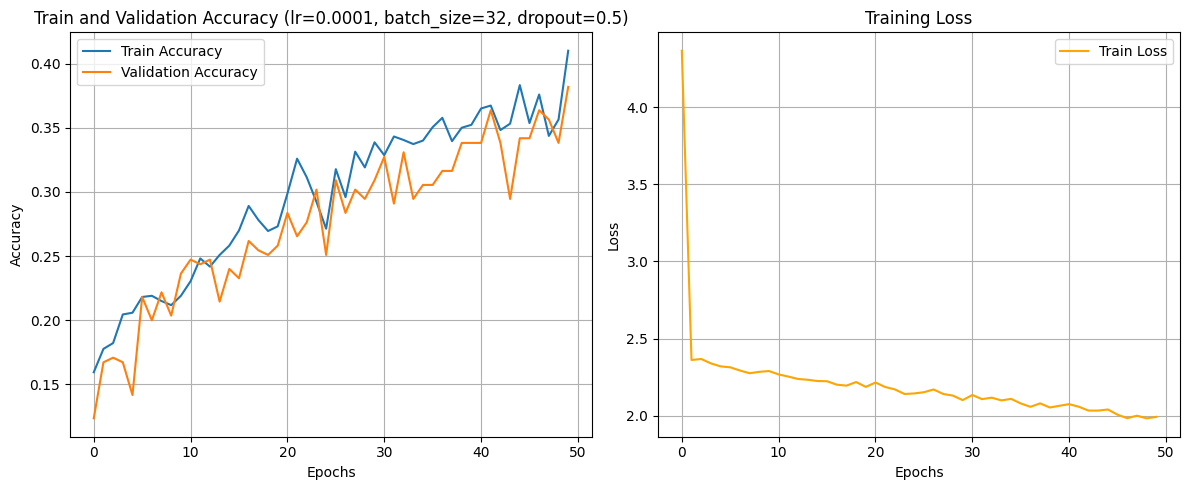

In [ ]:
model_dropout1 = BasicCNN_Dropout(dropout_prob=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_dropout1 = torch.optim.Adam(model_dropout1.parameters(), lr=0.0001)

train_loss_dropout1, train_acc_dropout1, val_acc_dropout1 = train_model(
    model_dropout1,
    train_loader,
    val_loader,
    criterion,
    optimizer_dropout1,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_dropout1, label='Train Accuracy')
plt.plot(val_acc_dropout1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32, dropout=0.5)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_dropout1, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_accuracy_03 = calculate_accuracy(model_dropout, test_loader)
print(f"Test Accuracy for Cnn Model with 0.3 Dropout: {test_accuracy_03:.4f}")

test_accuracy_05 = calculate_accuracy(model_dropout1, test_loader)
print(f"Test Accuracy for Cnn Model with 0.5 Dropout: {test_accuracy_05:.4f}")

Test Accuracy for Cnn Model with 0.3 Dropout: 0.3891
Test Accuracy for Cnn Model with 0.5 Dropout: 0.3236


### Confusion Matrix

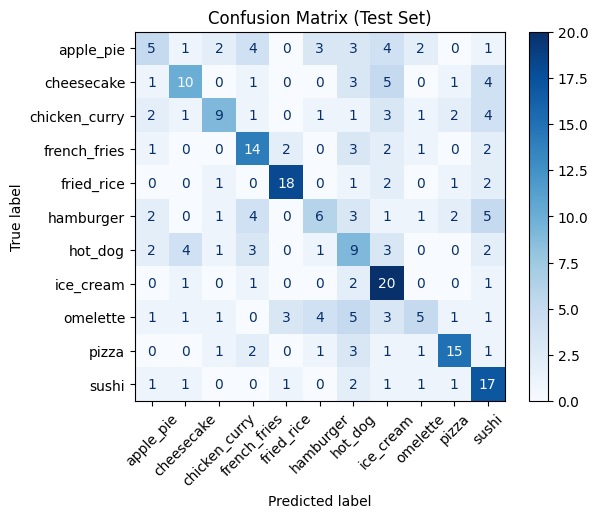

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            preds += predicted.cpu().tolist()
            labels += y.cpu().tolist()

    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix (Test Set)")
    plt.grid(False)
    plt.show()

# class names are taken from train_dataset
class_names = train_dataset.classes

# Confusion Matrix
plot_confusion_matrix(best_model, test_loader, class_names)

## **Residual CNN Models with Different Batchsize and Learning Rates**

Batchsize = 32, Learning Rate = 0.001

Epoch [1/50] - Loss: 22.0564, Train Acc: 0.1050, Val Acc: 0.0945
Epoch [2/50] - Loss: 2.3973, Train Acc: 0.1118, Val Acc: 0.0873
Epoch [3/50] - Loss: 2.3935, Train Acc: 0.0900, Val Acc: 0.0691
Epoch [4/50] - Loss: 2.3882, Train Acc: 0.1277, Val Acc: 0.0836
Epoch [5/50] - Loss: 2.3723, Train Acc: 0.1182, Val Acc: 0.1273
Epoch [6/50] - Loss: 2.3877, Train Acc: 0.1318, Val Acc: 0.1018
Epoch [7/50] - Loss: 2.3717, Train Acc: 0.1495, Val Acc: 0.1527
Epoch [8/50] - Loss: 2.3521, Train Acc: 0.1550, Val Acc: 0.1164
Epoch [9/50] - Loss: 2.3529, Train Acc: 0.1436, Val Acc: 0.1309
Epoch [10/50] - Loss: 2.3397, Train Acc: 0.1741, Val Acc: 0.1636
Epoch [11/50] - Loss: 2.3321, Train Acc: 0.1718, Val Acc: 0.1600
Epoch [12/50] - Loss: 2.3019, Train Acc: 0.1877, Val Acc: 0.1491
Epoch [13/50] - Loss: 2.3240, Train Acc: 0.1873, Val Acc: 0.1491
Epoch [14/50] - Loss: 2.3134, Train Acc: 0.1541, Val Acc: 0.1309
Epoch [15/50] - Loss: 2.2794, Train Acc: 0.2191, Val Acc: 0.2000
Epoch [16/50] - Loss: 2.2510, Tra

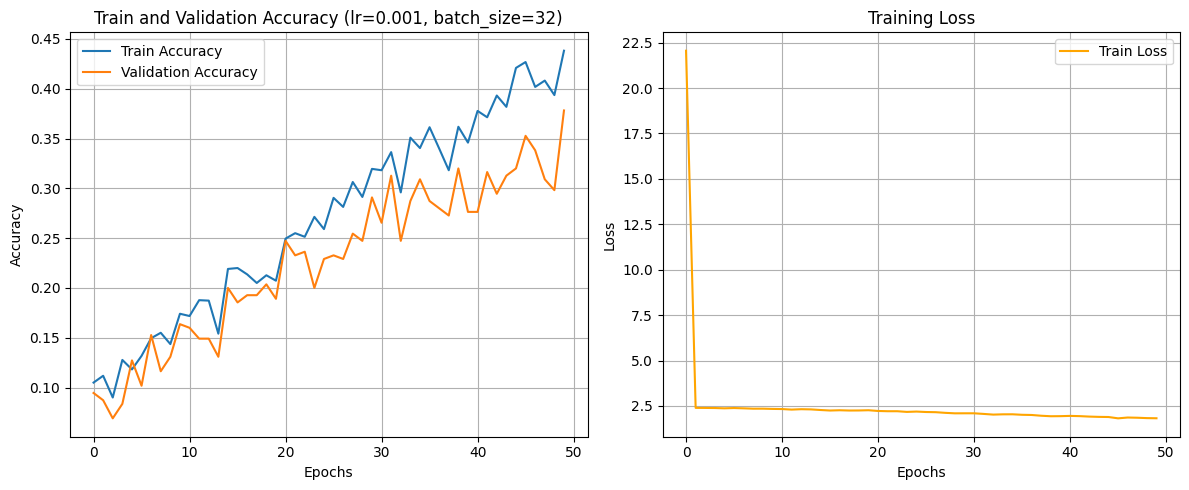

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = get_dataloaders(batch_size)

residual_model = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer = torch.optim.Adam(residual_model.parameters(), lr=0.001)

residual_train_loss, residual_train_acc, residual_val_acc = train_model(
    residual_model,
    train_loader,
    val_loader,
    criterion,
    residual_optimizer,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc, label='Train Accuracy')
plt.plot(residual_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.001, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 32, Learning Rate = 0.0001

Epoch [1/50] - Loss: 21.7631, Train Acc: 0.1045, Val Acc: 0.1273
Epoch [2/50] - Loss: 2.3919, Train Acc: 0.1414, Val Acc: 0.1491
Epoch [3/50] - Loss: 2.3737, Train Acc: 0.1477, Val Acc: 0.1455
Epoch [4/50] - Loss: 2.3444, Train Acc: 0.1900, Val Acc: 0.1927
Epoch [5/50] - Loss: 2.3321, Train Acc: 0.1755, Val Acc: 0.1455
Epoch [6/50] - Loss: 2.3078, Train Acc: 0.1814, Val Acc: 0.1600
Epoch [7/50] - Loss: 2.2880, Train Acc: 0.1864, Val Acc: 0.1709
Epoch [8/50] - Loss: 2.2694, Train Acc: 0.2136, Val Acc: 0.1673
Epoch [9/50] - Loss: 2.2672, Train Acc: 0.2150, Val Acc: 0.1855
Epoch [10/50] - Loss: 2.2618, Train Acc: 0.2245, Val Acc: 0.2436
Epoch [11/50] - Loss: 2.2483, Train Acc: 0.2114, Val Acc: 0.1891
Epoch [12/50] - Loss: 2.2413, Train Acc: 0.2200, Val Acc: 0.1927
Epoch [13/50] - Loss: 2.2242, Train Acc: 0.2473, Val Acc: 0.2327
Epoch [14/50] - Loss: 2.2258, Train Acc: 0.2500, Val Acc: 0.2145
Epoch [15/50] - Loss: 2.1958, Train Acc: 0.2268, Val Acc: 0.2145
Epoch [16/50] - Loss: 2.1934, Tra

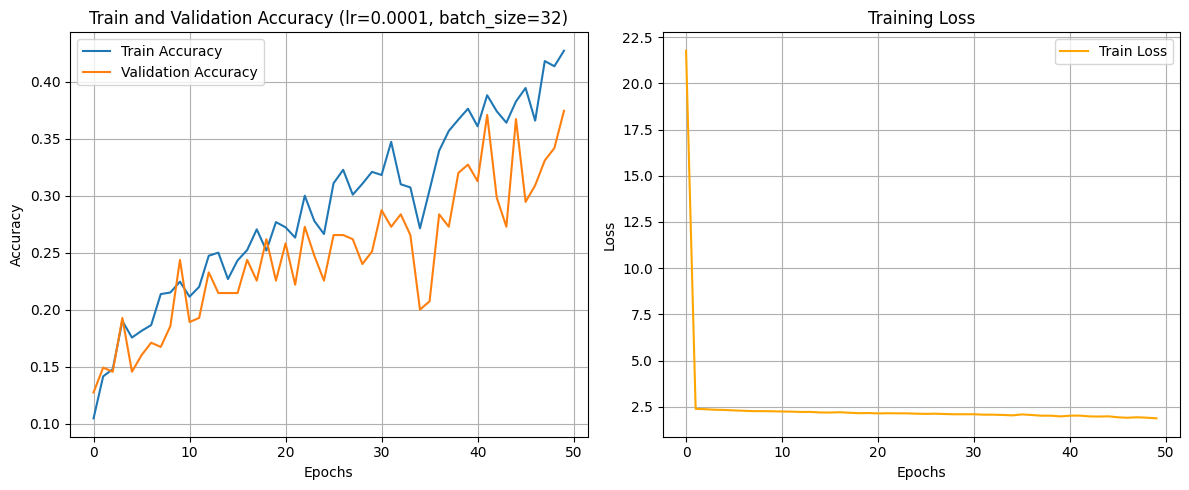

In [ ]:
residual_model1 = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer1 = torch.optim.Adam(residual_model1.parameters(), lr=0.0001)

residual_train_loss1, residual_train_acc1, residual_val_acc1 = train_model(
    residual_model1,
    train_loader,
    val_loader,
    criterion,
    residual_optimizer1,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc1, label='Train Accuracy')
plt.plot(residual_val_acc1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss1, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 32, Learning Rate = 0.0005

Epoch [1/50] - Loss: 19.0378, Train Acc: 0.1232, Val Acc: 0.0945
Epoch [2/50] - Loss: 2.3762, Train Acc: 0.1559, Val Acc: 0.1164
Epoch [3/50] - Loss: 2.3335, Train Acc: 0.1918, Val Acc: 0.2000
Epoch [4/50] - Loss: 2.3142, Train Acc: 0.2168, Val Acc: 0.1818
Epoch [5/50] - Loss: 2.2575, Train Acc: 0.2345, Val Acc: 0.2036
Epoch [6/50] - Loss: 2.2522, Train Acc: 0.2627, Val Acc: 0.2073
Epoch [7/50] - Loss: 2.2326, Train Acc: 0.2777, Val Acc: 0.2436
Epoch [8/50] - Loss: 2.2144, Train Acc: 0.3032, Val Acc: 0.2655
Epoch [9/50] - Loss: 2.1842, Train Acc: 0.3168, Val Acc: 0.2691
Epoch [10/50] - Loss: 2.1340, Train Acc: 0.3086, Val Acc: 0.3055
Epoch [11/50] - Loss: 2.1123, Train Acc: 0.3414, Val Acc: 0.2982
Epoch [12/50] - Loss: 2.0865, Train Acc: 0.3564, Val Acc: 0.3091
Epoch [13/50] - Loss: 2.0621, Train Acc: 0.3727, Val Acc: 0.3636
Epoch [14/50] - Loss: 2.0247, Train Acc: 0.3855, Val Acc: 0.3236
Epoch [15/50] - Loss: 2.0208, Train Acc: 0.3732, Val Acc: 0.3527
Epoch [16/50] - Loss: 2.0020, Tra

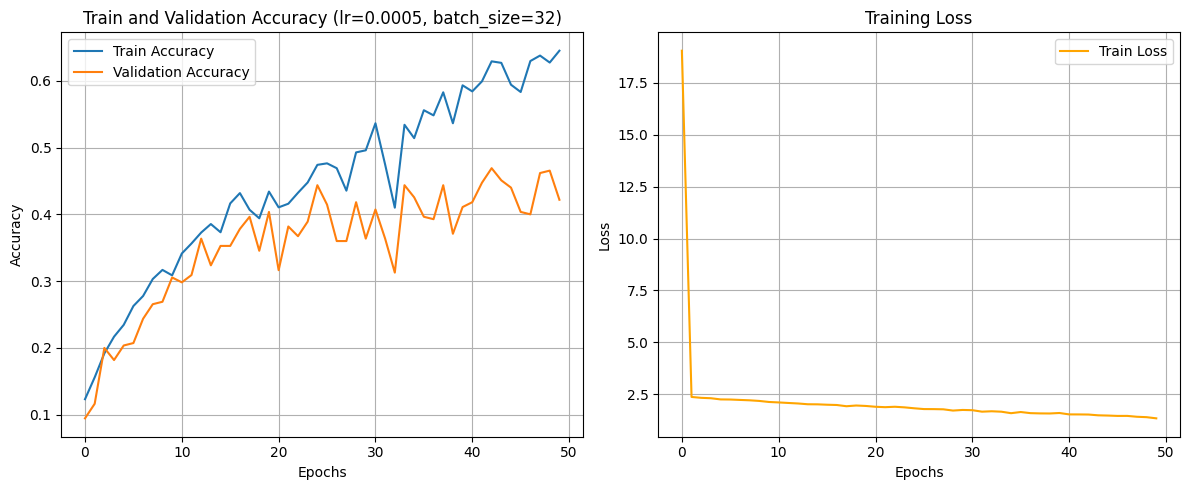

In [ ]:
residual_model2 = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer2 = torch.optim.Adam(residual_model2.parameters(), lr=0.0005)

residual_train_loss2, residual_train_acc2, residual_val_acc2 = train_model(
    residual_model2,
    train_loader,
    val_loader,
    criterion,
    residual_optimizer2,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc2, label='Train Accuracy')
plt.plot(residual_val_acc2, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0005, batch_size=32)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss2, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, Learning Rate = 0.001

Epoch [1/50] - Loss: 37.6892, Train Acc: 0.1005, Val Acc: 0.1055
Epoch [2/50] - Loss: 2.3881, Train Acc: 0.1345, Val Acc: 0.1273
Epoch [3/50] - Loss: 2.3467, Train Acc: 0.1705, Val Acc: 0.1673
Epoch [4/50] - Loss: 2.3148, Train Acc: 0.1691, Val Acc: 0.1418
Epoch [5/50] - Loss: 2.3133, Train Acc: 0.2036, Val Acc: 0.1964
Epoch [6/50] - Loss: 2.2884, Train Acc: 0.1886, Val Acc: 0.1673
Epoch [7/50] - Loss: 2.2552, Train Acc: 0.2336, Val Acc: 0.2182
Epoch [8/50] - Loss: 2.2155, Train Acc: 0.2509, Val Acc: 0.2145
Epoch [9/50] - Loss: 2.1965, Train Acc: 0.2595, Val Acc: 0.2255
Epoch [10/50] - Loss: 2.2057, Train Acc: 0.2632, Val Acc: 0.2036
Epoch [11/50] - Loss: 2.1790, Train Acc: 0.2841, Val Acc: 0.2618
Epoch [12/50] - Loss: 2.1418, Train Acc: 0.2932, Val Acc: 0.2691
Epoch [13/50] - Loss: 2.1165, Train Acc: 0.3055, Val Acc: 0.2800
Epoch [14/50] - Loss: 2.0989, Train Acc: 0.3214, Val Acc: 0.2582
Epoch [15/50] - Loss: 2.1326, Train Acc: 0.3086, Val Acc: 0.2764
Epoch [16/50] - Loss: 2.1261, Tra

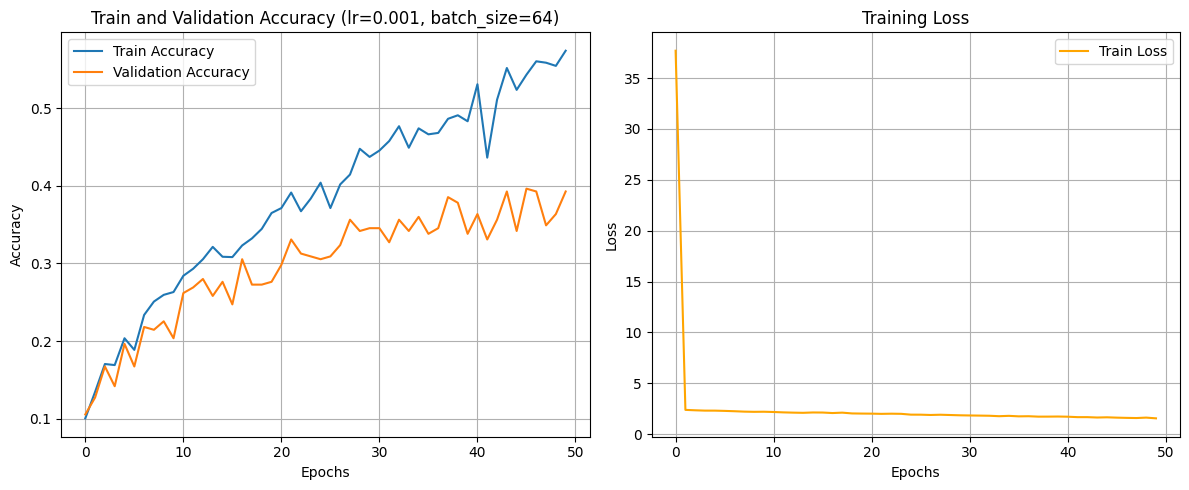

In [ ]:
batch_size_64 = 64
train_loader_64, val_loader_64, test_loader_64 = get_dataloaders(batch_size_64)

residual_model3 = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer3 = torch.optim.Adam(residual_model3.parameters(), lr=0.001)

residual_train_loss3, residual_train_acc3, residual_val_acc3 = train_model(
    residual_model3,
    train_loader_64,
    val_loader_64,
    criterion,
    residual_optimizer3,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc3, label='Train Accuracy')
plt.plot(residual_val_acc3, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.001, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss3, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, Learning Rate = 0.0001

Epoch [1/50] - Loss: 45.9711, Train Acc: 0.0882, Val Acc: 0.1018
Epoch [2/50] - Loss: 2.3888, Train Acc: 0.1195, Val Acc: 0.1491
Epoch [3/50] - Loss: 2.3901, Train Acc: 0.1359, Val Acc: 0.1309
Epoch [4/50] - Loss: 2.3586, Train Acc: 0.1918, Val Acc: 0.1709
Epoch [5/50] - Loss: 2.3071, Train Acc: 0.2014, Val Acc: 0.1927
Epoch [6/50] - Loss: 2.2885, Train Acc: 0.2250, Val Acc: 0.1891
Epoch [7/50] - Loss: 2.2714, Train Acc: 0.2223, Val Acc: 0.2000
Epoch [8/50] - Loss: 2.2432, Train Acc: 0.2491, Val Acc: 0.2145
Epoch [9/50] - Loss: 2.1965, Train Acc: 0.2745, Val Acc: 0.1964
Epoch [10/50] - Loss: 2.1797, Train Acc: 0.2709, Val Acc: 0.2473
Epoch [11/50] - Loss: 2.1784, Train Acc: 0.2827, Val Acc: 0.2473
Epoch [12/50] - Loss: 2.1556, Train Acc: 0.3245, Val Acc: 0.3091
Epoch [13/50] - Loss: 2.0956, Train Acc: 0.3314, Val Acc: 0.3382
Epoch [14/50] - Loss: 2.0738, Train Acc: 0.3164, Val Acc: 0.3091
Epoch [15/50] - Loss: 2.0599, Train Acc: 0.3455, Val Acc: 0.3236
Epoch [16/50] - Loss: 2.0463, Tra

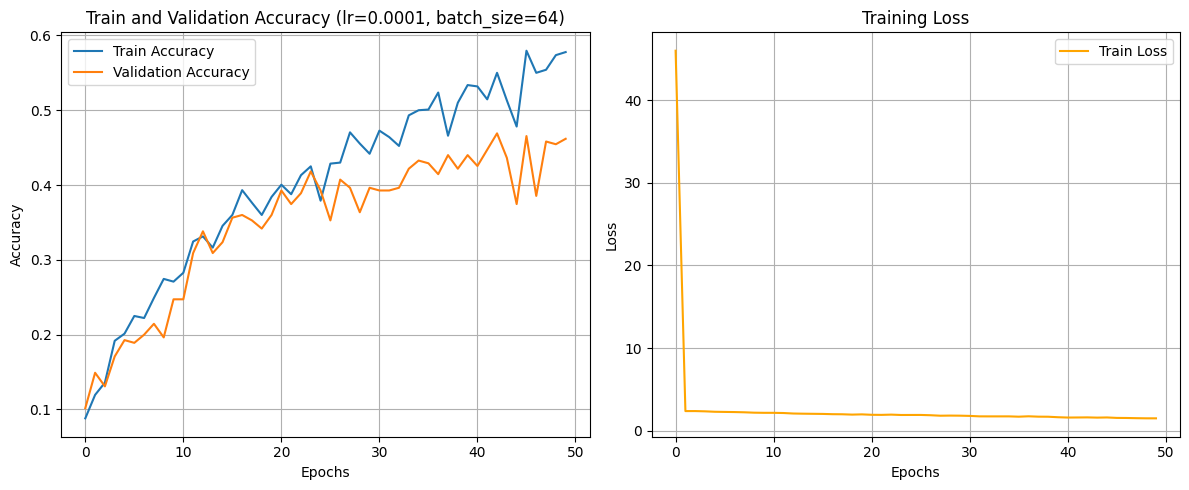

In [ ]:
residual_model4 = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer4 = torch.optim.Adam(residual_model4.parameters(), lr=0.0001)

residual_train_loss4, residual_train_acc4, residual_val_acc4 = train_model(
    residual_model4,
    train_loader_64,
    val_loader_64,
    criterion,
    residual_optimizer4,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc4, label='Train Accuracy')
plt.plot(residual_val_acc4, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss4, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, Learning Rate = 0.0005

Epoch [1/50] - Loss: 49.7825, Train Acc: 0.0964, Val Acc: 0.0727
Epoch [2/50] - Loss: 2.3957, Train Acc: 0.1205, Val Acc: 0.0945
Epoch [3/50] - Loss: 2.3913, Train Acc: 0.1418, Val Acc: 0.1345
Epoch [4/50] - Loss: 2.3802, Train Acc: 0.1327, Val Acc: 0.1200
Epoch [5/50] - Loss: 2.3600, Train Acc: 0.1623, Val Acc: 0.1527
Epoch [6/50] - Loss: 2.3180, Train Acc: 0.1732, Val Acc: 0.1382
Epoch [7/50] - Loss: 2.2932, Train Acc: 0.2018, Val Acc: 0.1855
Epoch [8/50] - Loss: 2.2728, Train Acc: 0.2195, Val Acc: 0.2000
Epoch [9/50] - Loss: 2.2512, Train Acc: 0.2323, Val Acc: 0.2327
Epoch [10/50] - Loss: 2.2319, Train Acc: 0.2164, Val Acc: 0.1782
Epoch [11/50] - Loss: 2.2841, Train Acc: 0.2427, Val Acc: 0.2255
Epoch [12/50] - Loss: 2.2061, Train Acc: 0.2618, Val Acc: 0.2618
Epoch [13/50] - Loss: 2.1703, Train Acc: 0.2800, Val Acc: 0.2618
Epoch [14/50] - Loss: 2.1600, Train Acc: 0.2914, Val Acc: 0.2727
Epoch [15/50] - Loss: 2.1485, Train Acc: 0.2923, Val Acc: 0.3164
Epoch [16/50] - Loss: 2.1137, Tra

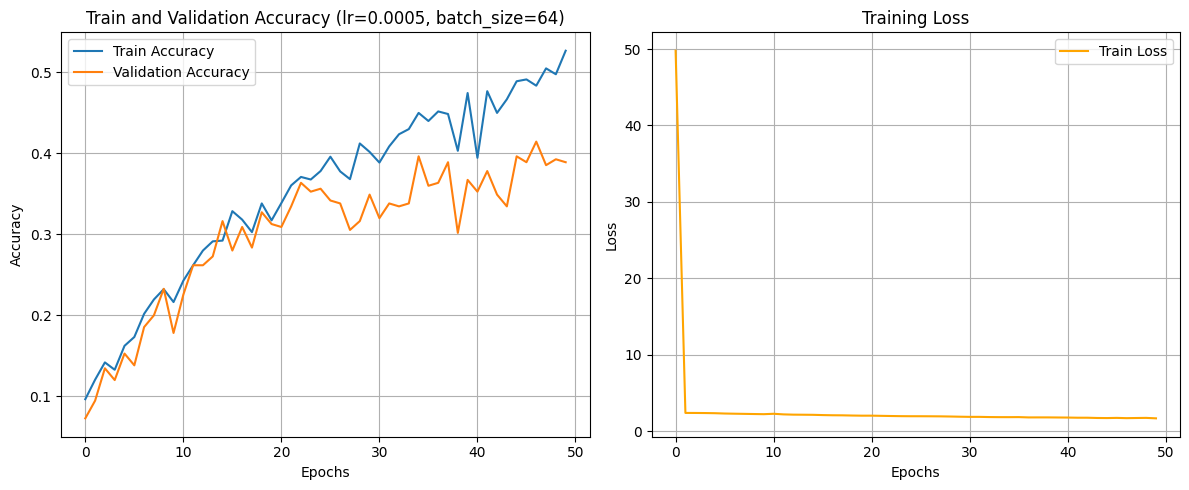

In [ ]:
residual_model5 = ResidualCNN().to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer5 = torch.optim.Adam(residual_model5.parameters(), lr=0.0005)

residual_train_loss5, residual_train_acc5, residual_val_acc5 = train_model(
    residual_model5,
    train_loader_64,
    val_loader_64,
    criterion,
    residual_optimizer5,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc5, label='Train Accuracy')
plt.plot(residual_val_acc5, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0005, batch_size=64)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss5, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**The best result was achieved at the learning rate of 0.0001 and batch size of 64.**

Loss: 1.5118, Train Acc: 0.5777, Val Acc: 0.4618

In [ ]:
residual_best_model = residual_model4
test_accuracy = calculate_accuracy(residual_best_model, test_loader)
print(f"Test Accuracy (with best validation model): {test_accuracy:.4f}")

Test Accuracy (with best validation model): 0.3745


### Residual CNN with Dropout Probability

In [ ]:
class ResidualCNN_Dropout(nn.Module):
    def __init__(self, num_classes=11, dropout_prob=0.5):
        super(ResidualCNN_Dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(64, 64),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            ResidualBlock(128, 256),
        )

        self.flatten_size = self._get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, num_classes),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)  # Dummy input
            out = self.features(dummy)
            return out.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Batchsize = 64, Learning Rate = 0.0001, Dropout Probability = 0.3

Epoch [1/50] - Loss: 16.8805, Train Acc: 0.1395, Val Acc: 0.1345
Epoch [2/50] - Loss: 2.3468, Train Acc: 0.2032, Val Acc: 0.2000
Epoch [3/50] - Loss: 2.2867, Train Acc: 0.2391, Val Acc: 0.1964
Epoch [4/50] - Loss: 2.2315, Train Acc: 0.2532, Val Acc: 0.2036
Epoch [5/50] - Loss: 2.1722, Train Acc: 0.3068, Val Acc: 0.2655
Epoch [6/50] - Loss: 2.1334, Train Acc: 0.3050, Val Acc: 0.2909
Epoch [7/50] - Loss: 2.0881, Train Acc: 0.3359, Val Acc: 0.3200
Epoch [8/50] - Loss: 2.0675, Train Acc: 0.3486, Val Acc: 0.3236
Epoch [9/50] - Loss: 2.0254, Train Acc: 0.3745, Val Acc: 0.3164
Epoch [10/50] - Loss: 1.9804, Train Acc: 0.3691, Val Acc: 0.3564
Epoch [11/50] - Loss: 1.9672, Train Acc: 0.3968, Val Acc: 0.3273
Epoch [12/50] - Loss: 1.9423, Train Acc: 0.4264, Val Acc: 0.3709
Epoch [13/50] - Loss: 1.8950, Train Acc: 0.4023, Val Acc: 0.3382
Epoch [14/50] - Loss: 1.8502, Train Acc: 0.4109, Val Acc: 0.3382
Epoch [15/50] - Loss: 1.8400, Train Acc: 0.3986, Val Acc: 0.3200
Epoch [16/50] - Loss: 1.7913, Tra

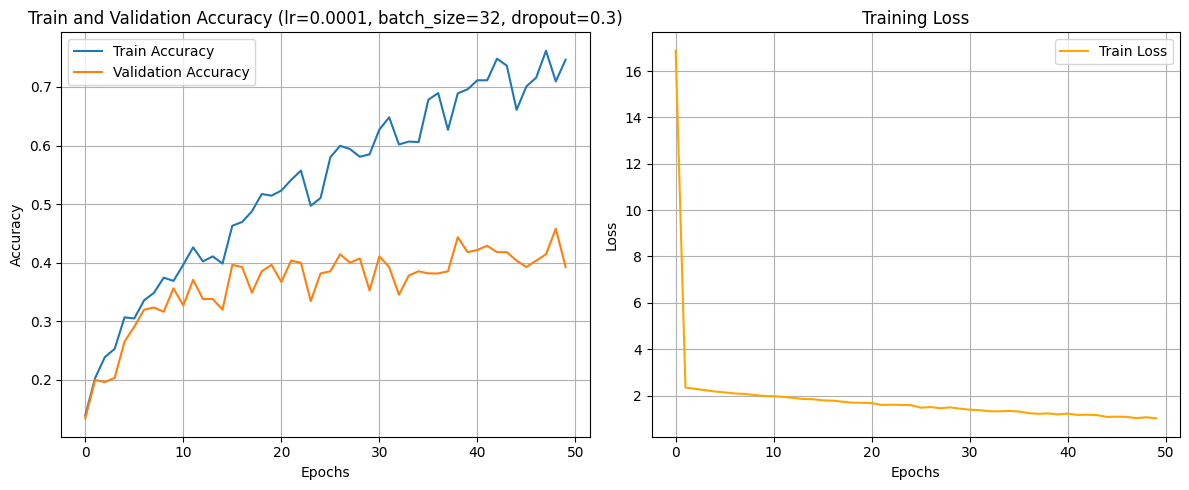

In [ ]:
residual_model_dropout = ResidualCNN_Dropout(dropout_prob=0.3).to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer_dropout = torch.optim.Adam(residual_model_dropout.parameters(), lr=0.0001)

residual_train_loss_dropout, residual_train_acc_dropout, residual_val_acc_dropout = train_model(
    residual_model_dropout,
    train_loader_64,
    val_loader_64,
    criterion,
    residual_optimizer_dropout,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc_dropout, label='Train Accuracy')
plt.plot(residual_val_acc_dropout, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32, dropout=0.3)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss_dropout, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Batchsize = 64, Learning Rate = 0.0001, Dropout Probability = 0.5

Epoch [1/50] - Loss: 17.8092, Train Acc: 0.1632, Val Acc: 0.1564
Epoch [2/50] - Loss: 2.3351, Train Acc: 0.2173, Val Acc: 0.2036
Epoch [3/50] - Loss: 2.2867, Train Acc: 0.2155, Val Acc: 0.2000
Epoch [4/50] - Loss: 2.2395, Train Acc: 0.2664, Val Acc: 0.2764
Epoch [5/50] - Loss: 2.2285, Train Acc: 0.2632, Val Acc: 0.2582
Epoch [6/50] - Loss: 2.1882, Train Acc: 0.2995, Val Acc: 0.2764
Epoch [7/50] - Loss: 2.1474, Train Acc: 0.3214, Val Acc: 0.2836
Epoch [8/50] - Loss: 2.0947, Train Acc: 0.3627, Val Acc: 0.3200
Epoch [9/50] - Loss: 2.0690, Train Acc: 0.3568, Val Acc: 0.3455
Epoch [10/50] - Loss: 2.0377, Train Acc: 0.3486, Val Acc: 0.3236
Epoch [11/50] - Loss: 2.0017, Train Acc: 0.3959, Val Acc: 0.3818
Epoch [12/50] - Loss: 2.0033, Train Acc: 0.3486, Val Acc: 0.3164
Epoch [13/50] - Loss: 1.9510, Train Acc: 0.4000, Val Acc: 0.3345
Epoch [14/50] - Loss: 1.9273, Train Acc: 0.4177, Val Acc: 0.3564
Epoch [15/50] - Loss: 1.9083, Train Acc: 0.4332, Val Acc: 0.3927
Epoch [16/50] - Loss: 1.8730, Tra

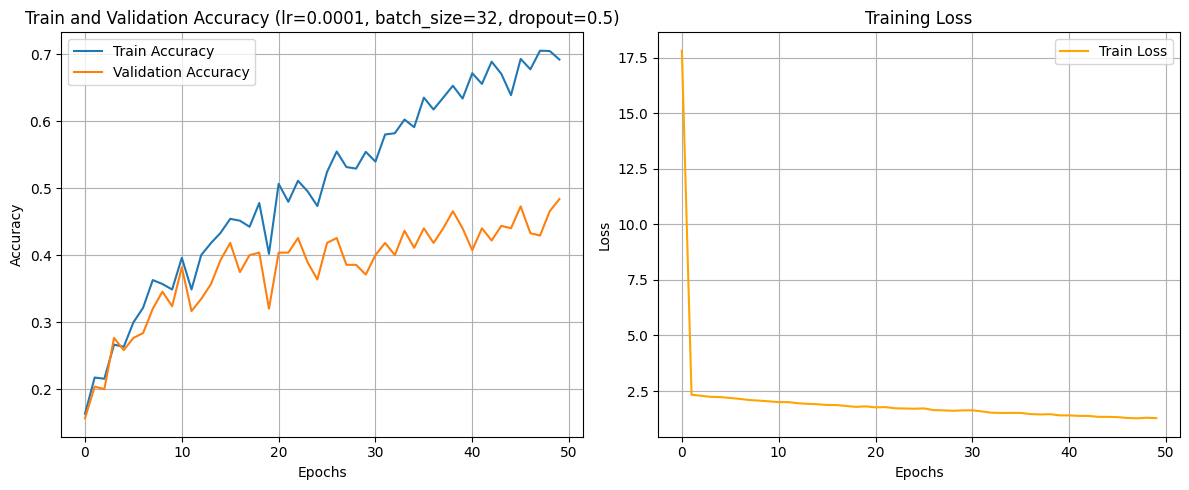

In [ ]:
residual_model_dropout1 = ResidualCNN_Dropout(dropout_prob=0.5).to(device)

criterion = nn.CrossEntropyLoss()
residual_optimizer_dropout1 = torch.optim.Adam(residual_model_dropout1.parameters(), lr=0.0001)

residual_train_loss_dropout1, residual_train_acc_dropout1, residual_val_acc_dropout1 = train_model(
    residual_model_dropout1,
    train_loader_64,
    val_loader_64,
    criterion,
    residual_optimizer_dropout1,
    num_epochs=50
)

plt.figure(figsize=(12, 5))

# Train and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(residual_train_acc_dropout1, label='Train Accuracy')
plt.plot(residual_val_acc_dropout1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy (lr=0.0001, batch_size=32, dropout=0.5)")
plt.legend()
plt.grid(True)

# Train Loss
plt.subplot(1, 2, 2)
plt.plot(residual_train_loss_dropout1, label='Train Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The best result was achieved at the learning rate of 0.0001 and batch size of 64 and dropout value of 0.5.

Loss: 1.2818, Train Acc: 0.6918, Val Acc: 0.4836

In [ ]:
residual_test_accuracy_03 = calculate_accuracy(residual_model_dropout, test_loader)
print(f"Test Accuracy for Residual Cnn Model with 0.3 Dropout: {residual_test_accuracy_03:.4f}")

residual_test_accuracy_05 = calculate_accuracy(residual_model_dropout1, test_loader)
print(f"Test Accuracy for Residual Cnn Model with 0.5 Dropout: {residual_test_accuracy_05:.4f}")

Test Accuracy for Residual Cnn Model with 0.3 Dropout: 0.3309
Test Accuracy for Residual Cnn Model with 0.5 Dropout: 0.3818


### Confusion Matrix for Residual CNN

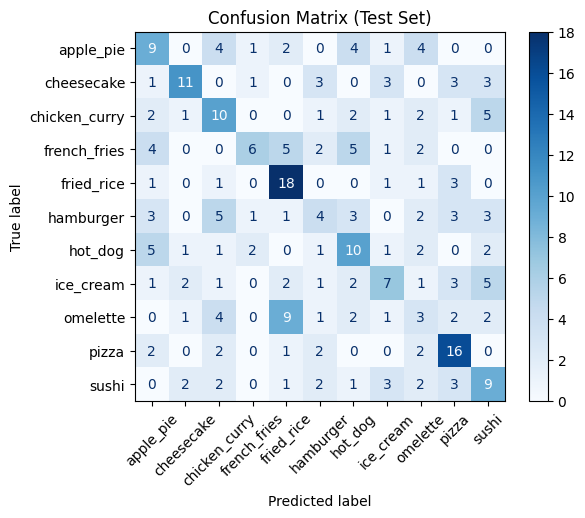

In [ ]:
# Confusion Matrix
residual_best_model = residual_model_dropout1
plot_confusion_matrix(residual_best_model, test_loader, class_names)

# PART 2

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load MobileNetV2 model as pretrained
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

for param in mobilenet_v2.parameters():
    param.requires_grad = False

mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, 11)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.0MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = mobilenet_v2.to(device)

In [ ]:
mn_criterion = nn.CrossEntropyLoss()
mn_optimizer = torch.optim.Adam(mobilenet_v2.classifier[1].parameters(), lr=0.0001)

In [ ]:
# DataLoaders
batch_size = 32

mn_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
mn_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
mn_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
mn_train_loss, mn_train_acc, mn_val_acc = train_model(
    mobilenet_v2,
    mn_train_loader,
    mn_val_loader,
    mn_criterion,
    mn_optimizer,
    num_epochs=50
)

Epoch [1/50] - Loss: 0.0763, Train Acc: 0.9932, Val Acc: 0.8945
Epoch [2/50] - Loss: 0.0872, Train Acc: 0.9959, Val Acc: 0.8909
Epoch [3/50] - Loss: 0.0853, Train Acc: 0.9927, Val Acc: 0.8982
Epoch [4/50] - Loss: 0.0862, Train Acc: 0.9932, Val Acc: 0.8945
Epoch [5/50] - Loss: 0.0794, Train Acc: 0.9968, Val Acc: 0.8945
Epoch [6/50] - Loss: 0.0862, Train Acc: 0.9955, Val Acc: 0.8909
Epoch [7/50] - Loss: 0.0778, Train Acc: 0.9941, Val Acc: 0.8909
Epoch [8/50] - Loss: 0.0715, Train Acc: 0.9964, Val Acc: 0.8945
Epoch [9/50] - Loss: 0.0865, Train Acc: 0.9941, Val Acc: 0.8909
Epoch [10/50] - Loss: 0.0767, Train Acc: 0.9950, Val Acc: 0.8909
Epoch [11/50] - Loss: 0.1012, Train Acc: 0.9932, Val Acc: 0.8909
Epoch [12/50] - Loss: 0.0755, Train Acc: 0.9945, Val Acc: 0.8836
Epoch [13/50] - Loss: 0.0897, Train Acc: 0.9955, Val Acc: 0.8836
Epoch [14/50] - Loss: 0.0781, Train Acc: 0.9936, Val Acc: 0.8873
Epoch [15/50] - Loss: 0.0882, Train Acc: 0.9941, Val Acc: 0.8945
Epoch [16/50] - Loss: 0.0724, Trai

In [ ]:
# before fine-tuning
mn_test_accuracy = calculate_accuracy(mobilenet_v2, mn_test_loader)
print(f"Test Accuracy for MobileNetV2 Cnn Model: {mn_test_accuracy:.4f}")

Test Accuracy for MobileNetV2 Cnn Model: 0.7855


In [ ]:
# Open the last blocks of the feature extractor (The last blocks of MobileNetV2 are 17 and 18)
for name, param in mobilenet_v2.features.named_parameters():
    if "17" in name or "18" in name:
        param.requires_grad = True

mn_optimizer_finetune = torch.optim.Adam(filter(lambda p: p.requires_grad, mobilenet_v2.parameters()), lr=0.00001)

# Start fine-tuning training
mn_train_loss_ft, mn_train_acc_ft, mn_val_acc_ft = train_model(
    mobilenet_v2,
    mn_train_loader,
    mn_val_loader,
    mn_criterion,
    mn_optimizer_finetune,
    num_epochs=10  # Fine-tuning is done in fewer epochs
)

Epoch [1/10] - Loss: 0.0672, Train Acc: 0.9968, Val Acc: 0.8873
Epoch [2/10] - Loss: 0.0802, Train Acc: 0.9995, Val Acc: 0.8800
Epoch [3/10] - Loss: 0.0769, Train Acc: 0.9945, Val Acc: 0.8873
Epoch [4/10] - Loss: 0.0719, Train Acc: 0.9945, Val Acc: 0.8873
Epoch [5/10] - Loss: 0.0620, Train Acc: 0.9959, Val Acc: 0.8836
Epoch [6/10] - Loss: 0.0725, Train Acc: 0.9964, Val Acc: 0.8764
Epoch [7/10] - Loss: 0.0609, Train Acc: 0.9964, Val Acc: 0.8836
Epoch [8/10] - Loss: 0.0729, Train Acc: 0.9977, Val Acc: 0.8982
Epoch [9/10] - Loss: 0.0660, Train Acc: 0.9959, Val Acc: 0.8945
Epoch [10/10] - Loss: 0.0612, Train Acc: 0.9964, Val Acc: 0.8909


In [ ]:
# after fine-tuning
mn_test_accuracy = calculate_accuracy(mobilenet_v2, mn_test_loader)
print(f"Test Accuracy for MobileNetV2 Cnn Model: {mn_test_accuracy:.4f}")

Test Accuracy for MobileNetV2 Cnn Model: 0.7782


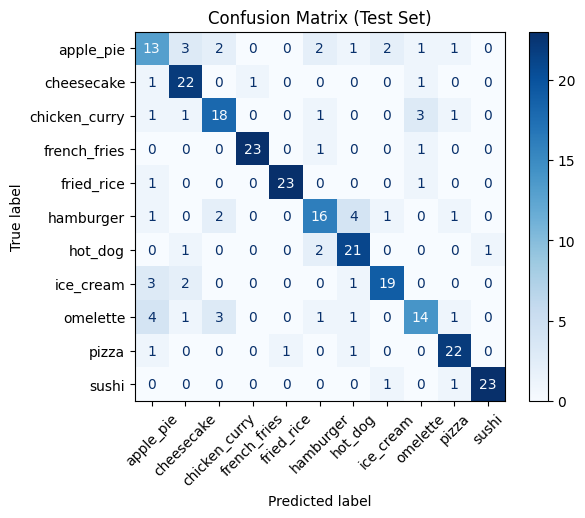

In [ ]:
# Confusion Matrix
plot_confusion_matrix(mobilenet_v2, mn_test_loader, class_names)